In [1]:
import os
import tempfile
from typing import Any, Dict, List

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import fastestimator as fe
from fastestimator.architecture.tensorflow import UNet
from fastestimator.dataset import montgomery
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import Delete, HorizontalFlip, Minmax, ReadImage, Resize, Rotate, Sometimes
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Dice

In [2]:
pd.set_option('display.max_colwidth', 500)

In [3]:
BATCH_SIZE = 4
EPOCHS = 20

# Download Data

We download the Montgomery data first:

In [4]:
csv = montgomery.load_data()

This creates a `CSVDataset`, let's see what is inside:

In [5]:
df = pd.DataFrame.from_dict(csv.data, orient='index')

In [6]:
df.head()

,image,mask_left,mask_right
0,MontgomerySet/CXR_png/MCUCXR_0243_1.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0243_1.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0243_1.png
1,MontgomerySet/CXR_png/MCUCXR_0022_0.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0022_0.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0022_0.png
2,MontgomerySet/CXR_png/MCUCXR_0086_0.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0086_0.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0086_0.png
3,MontgomerySet/CXR_png/MCUCXR_0008_0.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0008_0.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0008_0.png
4,MontgomerySet/CXR_png/MCUCXR_0094_0.png,MontgomerySet/ManualMask/leftMask/MCUCXR_0094_0.png,MontgomerySet/ManualMask/rightMask/MCUCXR_0094_0.png


# Building Components

We are going to setup the stage for training. 

## Step 1: Create Pipeline

In [7]:
class CombineLeftRightMask(NumpyOp):
    def forward(self, data: List[np.ndarray], state: Dict[str, Any]) -> List[np.ndarray]:
        mask_left, mask_right = data
        data = mask_left + mask_right
        return data

In [8]:
pipeline = fe.Pipeline(
    train_data=csv,
    eval_data=csv.split(0.2),
    batch_size=BATCH_SIZE,
    ops=[
        ReadImage(inputs="image", parent_path=csv.parent_path, outputs="image", grey_scale=True),
        ReadImage(inputs="mask_left", parent_path=csv.parent_path, outputs="mask_left", grey_scale=True, mode='!infer'),
        ReadImage(inputs="mask_right",
                  parent_path=csv.parent_path,
                  outputs="mask_right",
                  grey_scale=True,
                  mode='!infer'),
        CombineLeftRightMask(inputs=("mask_left", "mask_right"), outputs="mask", mode='!infer'),
        Delete(keys=["mask_left", "mask_right"], mode='!infer'),
        Resize(image_in="image", width=512, height=512),
        Resize(image_in="mask", width=512, height=512, mode='!infer'),
        Sometimes(numpy_op=HorizontalFlip(image_in="image", mask_in="mask", mode='train')),
        Sometimes(numpy_op=Rotate(
            image_in="image", mask_in="mask", limit=(-10, 10), border_mode=cv2.BORDER_CONSTANT, mode='train')),
        Minmax(inputs="image", outputs="image"),
        Minmax(inputs="mask", outputs="mask", mode='!infer')
    ])

Let's see if the `Pipeline` output is reasonable. We call `get_results` to get outputs from `Pipeline`.

In [9]:
batch_data = pipeline.get_results()

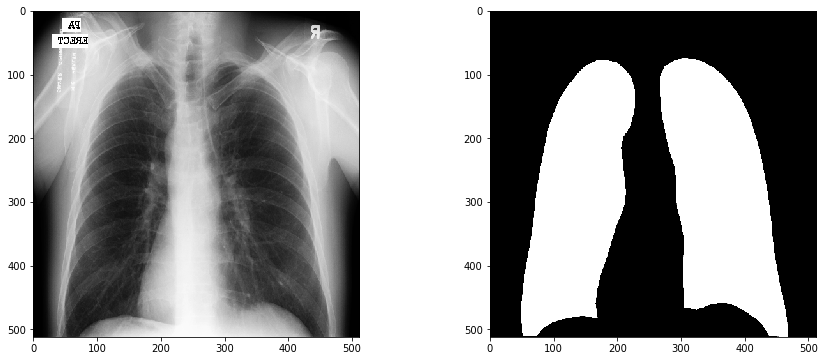

In [28]:
batch_index = 1
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].imshow(np.squeeze(batch_data['image'][batch_index]), cmap='gray')
ax[1].imshow(np.squeeze(batch_data['mask'][batch_index]), cmap='gray')

## Step 2: Create Network

In [11]:
model = fe.build(model_fn=lambda: UNet(input_size=(512, 512, 1)),
                 optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.0001),
                 model_names="lung_segmentation")

In [12]:
network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs="pred_segment"),
    CrossEntropy(inputs=("pred_segment", "mask"), outputs="loss", form="binary"),
    UpdateOp(model=model, loss_name="loss")
])

## Step 3: Create Estimator

In [13]:
traces = [
    Dice(true_key="mask", pred_key="pred_segment"),
    BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric='dice', save_best_mode='max')
]

In [14]:
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=EPOCHS,
                         log_steps=20,
                         traces=traces,
                         max_steps_per_epoch=None)

# Training

This training takes about 5 minutes using 1 V100 GPU.

In [15]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 0; lung_segmentation_lr: 1e-04; 
FastEstimator-Train: step: 0; loss: 0.6547433; 
FastEstimator-Train: step: 20; loss: 0.33521438; steps/sec: 3.27; 
FastEstimator-Train: step: 28; epoch: 0; epoch_time: 20.42 sec; 
Saved model to /tmp/tmp672rlhfj/lung_segmentation_best_dice.h5
FastEstimator-Eval: step: 28; epoch: 0; loss: 0.34206337; min_loss: 0.34206337; since_best: 0; dice: 0.22620882194282815; 
FastEstimator-Train: step: 40; loss: 0.16766289; steps/sec: 1.71; 
FastEstimator-Train: step: 56; epoch: 1; epoch_time: 11.15 sec; 
Sav

# Inferencing

Let's visualize the prediction from the neural network. We select a radom image from the dataset.

In [16]:
image_path = df['image'].sample(random_state=3).values[0]

## Pass Image through Pipeline and Network

We create a data dict, and call `Pipeline.transform()`.

In [17]:
data = {'image': image_path}
data = pipeline.transform(data, mode="infer")

After the pipeline, we rebuild the model by providing the trained weights path and a new network.

In [18]:
model = fe.build(model_fn=lambda: UNet(input_size=(512, 512, 1)),
                 optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.0001),
                 model_names="lung_segmentation",
                 weights_path='PATH_TO_MODEL')

Loaded model weights from /tmp/tmpci14638v/lung_segmentation_best_dice.h5


In [19]:
network = fe.Network(ops=[ModelOp(inputs="image", model=model, outputs="pred_segment")])

We call `Network.transform()` to get outputs from our network.

In [20]:
pred = network.transform(data, mode="infer")

## Visualize Outputs

In [21]:
img = np.squeeze(pred['image'])
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_rgb = (img_rgb * 255).astype(np.uint8)

In [22]:
mask = pred['pred_segment'].numpy()
mask = np.squeeze(mask)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
mask_rgb = (mask_rgb * 255).astype(np.uint8)

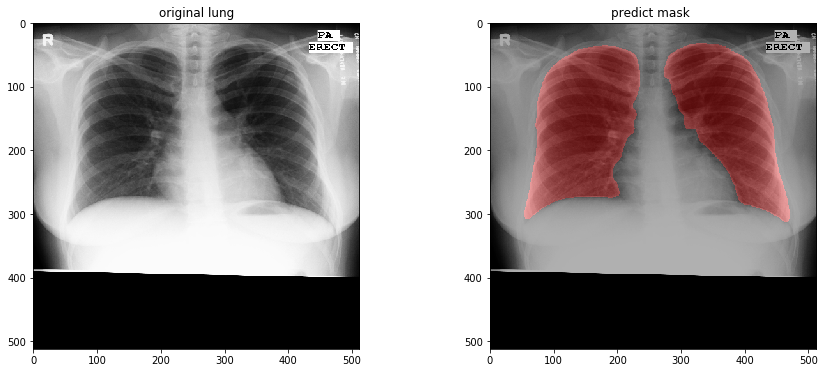

In [29]:
_, mask_thres = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)
mask_overlay = mask_rgb * np.expand_dims(mask_thres, axis=-1)
mask_overlay = np.where(mask_overlay != [0, 0, 0], [255, 0, 0], [0, 0, 0])
mask_overlay = mask_overlay.astype(np.uint8)
img_with_mask = cv2.addWeighted(img_rgb, 0.7, mask_overlay, 0.3, 0)
maskgt_with_maskpred = cv2.addWeighted(mask_rgb, 0.7, mask_overlay, 0.3, 0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].imshow(img_rgb)
ax[0].set_title('original lung')
ax[1].imshow(img_with_mask)
ax[1].set_title('predict mask ')
plt.show()